In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import tensorflow_hub as hub

import pandas as pd
import numpy as np
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from sklearn.utils import class_weight
from collections import defaultdict
import matplotlib.pyplot as plt

from src.embeddings import get_embedding_dictionnary, get_embeddings_and_word_index, sequences_to_index
from src.dataset import load_dataset, load_datasets_and_vocab_pipeline, train_test_val_split
from src.evaluate import get_metrics, get_predictions
from src.models import model_mine
from src.submission import generate_predictions

# embeddings_path = '../sentiment_analysis/data/embeddings/datastories.twitter.300d.txt'

Using TensorFlow backend.
/home/epita/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [3]:
url = "https://tfhub.dev/google/elmo/2"
embed = hub.Module(url)

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Downloading TF-Hub Module 'https://tfhub.dev/google/elmo/2'.
INFO:tensorflow:Downloaded https://tfhub.dev/google/elmo/2, Total size: 357.40MB
INFO:tensorflow:Downloaded TF-Hub Module 'https://tfhub.dev/google/elmo/2'.
INFO:tensorflow:Initialize variable module/aggregation/scaling:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with aggregation/scaling
INFO:tensorflow:Initialize variable module/aggregation/weights:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with aggregation/weights
INFO:tensorflow:Initialize variable module/bilm/CNN/W_cnn_0:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_0
INFO:tensorflow:Initialize variable module/bilm/CNN/W_cnn_1:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variab

INFO:tensorflow:Initialize variable module/bilm/char_embed:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/char_embed


### Load and preprocess Train and Test

In [46]:
(X_train, y_train), (X_test, y_test), (vocab, max_seq_len) = load_datasets_and_vocab_pipeline()

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


Building vocabulary...: 100%|██████████| 32915/32915 [00:00<00:00, 108083.95it/s]


In [47]:
X_train.shape, X_train.values.shape, X_test.shape, y_test.values.shape

((30160,), (30160,), (2755,), (2755,))

### Compute the classes weights because our dataset is largely unbalanced

In [6]:
cls_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
cls_weights

array([1.36941518, 1.77704454, 1.38019403, 0.50441531])

### Create an embedding matrix for our vocabulary

In [6]:
emb_matrix, word_index, unknown_words = get_embeddings_and_word_index(embeddings_path, max_seq_len, vocab)
# Unknown words: 1303

print(f'{len(unknown_words) / len(vocab) * 100:.2f}% of our vocabulary are unknown words to the embedding matrix')

8.84% of our vocabulary are unknown words to the embedding matrix


### Spellcheck testing

In [7]:
from autocorrect import spell

In [8]:
l_unkown = list(unknown_words.keys())

In [9]:
from multiprocessing import Pool

def spellcheck(word):
    return word, spell(word)

with Pool(processes=6) as pool:
    res = list(pool.map(spellcheck, l_unkown))
    corr_2 = {k: v for (k,v) in res}

In [10]:
emb_dict = get_embedding_dictionnary(embeddings_path)

In [11]:
still_unknown = defaultdict(int)

for word, correction in corr_2.items():
    correction = correction.lower()
    if len(word) > 2 and word != correction:
        index = word_index[word]
        if correction in emb_dict:
            emb_matrix[index] = emb_dict[correction]
        elif correction in word_index:
            print(f'{correction} (from {word}) in word_index')
        else:
            still_unknown[(word, correction)] += 1
    else:
        still_unknown[(word, correction)] += 1

len(still_unknown)

530

In [12]:
still_unknown_word = set(k[0] for k in still_unknown.keys())

In [13]:
replaced_word = [(k, corr_2[k]) for k in unknown_words.keys() - still_unknown_word]

len(replaced_word)

773

In [14]:
('angru', 'angry') in replaced_word

True

### Transforming our sequences of words to indexes

In [15]:
X_train = sequences_to_index(X_train, word_index, max_seq_len)
X_test = sequences_to_index(X_test, word_index, max_seq_len)

X_train.shape, X_test.shape

((30160, 163), (2755, 163))

### Training

In [65]:
X_train = np.vectorize(lambda x: ' '.join(x))(X_train)

In [66]:
X_test = np.vectorize(lambda x: ' '.join(x))(X_test)

In [67]:
y_train = to_categorical(y_train, 4) if len(y_train.shape) == 1 else y_train
y_test = to_categorical(y_test, 4) if len(y_test.shape) == 1 else y_test
(x_trn, y_trn), (x_val, y_val) = train_test_val_split(X_train, y_train)
# (x_trn, y_trn), (x_val, y_val), (x_tst, y_tst) = train_test_val_split(X_train, y_train)

print('training set: ' + str(len(x_trn)) + ' samples')
print('validation set: ' + str(len(x_val)) + ' samples')
# print('validation_test set: ' + str(len(x_tst)) + ' samples')

print('x_train:', x_trn.shape)
print('y_train:', y_trn.shape)

training set: 21111 samples
validation set: 9049 samples
x_train: (21111,)
y_train: (21111, 4)


In [41]:
cls_weights = np.array([1.36941518, 1.77704454, 1.38019403, 0.50441531])
cls_weights

array([1.36941518, 1.77704454, 1.38019403, 0.50441531])

In [45]:
batch_size = 64

In [120]:
import keras.backend as K
from keras.layers import Input, Lambda, Dense, Flatten, Reshape
from keras.models import Model
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda


def ELMoEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["elmo"]

input_text = Input(shape=(1,), dtype=tf.string)
embedding = Lambda(ELMoEmbedding, output_shape=(1024,))(input_text)
x = Bidirectional(LSTM(units=512, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))(embedding)
# x_rnn = Bidirectional(LSTM(units=512, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))(x)
# x = add([x, x_rnn])  # residual connection to the first biLSTM
# pred = TimeDistributed(Dense(4, activation="softmax"))(x)
dense = Flatten()(x)
pred = Dense(4, activation='softmax')(dense)
model = Model(inputs=[input_text], outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'

In [ ]:
model.summary()

In [ ]:
callbacks_list = [
        ModelCheckpoint(filepath='pickles/models/elmo-best.h5', save_best_only=True, verbose=1, save_weights_only=True),
        EarlyStopping(patience=3, verbose=0)
    ]

In [119]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
#     model.load_weights('pickles/models/elmo-best.h5')
    history = model.fit(x_trn, y_trn, epochs=1, batch_size=batch_size, validation_data=(x_val, y_val), callbacks=callbacks_list, class_weight=cls_weights)

Train on 21111 samples, validate on 9049 samples
Epoch 1/1


InvalidArgumentError: Matrix size-incompatible: In[0]: [64,43008], In[1]: [166912,4]
	 [[Node: dense_31/MatMul = MatMul[T=DT_FLOAT, _class=["loc:@training_6/Adam/gradients/dense_31/MatMul_grad/MatMul"], transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](flatten_5/Reshape, dense_31/kernel/read)]]
	 [[Node: loss_18/mul/_567 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_5356_loss_18/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

In [43]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    model.load_weights('pickles/models/elmo-best.h5')  
    predicts = model.predict(X_test, batch_size=batch_size)

True Positives per class :  [ 102.   90.   91. 1889.]
False Positives per class :  [183. 148. 164.  88.]
False Negatives per class :  [ 48.  52.  34. 449.]

Class angry : Precision : 0.358, Recall : 0.680, F1 : 0.469
Class happy : Precision : 0.378, Recall : 0.634, F1 : 0.474
Class sad : Precision : 0.357, Recall : 0.728, F1 : 0.479

Ignoring the Others class, Macro Precision : 0.3643, Macro Recall : 0.6806, Macro F1 : 0.4746
Ignoring the Others class, Micro TP : 283, FP : 495, FN : 134

Accuracy : 0.7884, Micro Precision : 0.3638, Micro Recall : 0.6787, Micro F1 : 0.4736


(0.7883847549909256, 0.3637532, 0.67865705, 0.47364015093946804)

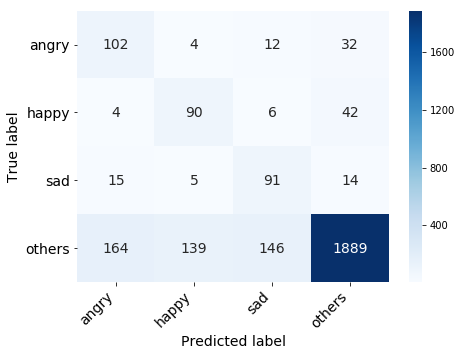

In [44]:
get_metrics(predicts, y_test)

### Evaluating our model

In [61]:
model = load_model('pickles/models/best.h5')

In [17]:
last_best = load_model('pickles/models/val_acc_0.888-tst_f1_0.869-res_f1_0.694.h5')

#### Validation set

True Positives per class :  [1422. 1067. 1521. 4097.]
False Positives per class :  [171. 138. 190. 443.]
False Negatives per class :  [229. 193. 153. 367.]

Class angry : Precision : 0.893, Recall : 0.861, F1 : 0.877
Class happy : Precision : 0.885, Recall : 0.847, F1 : 0.866
Class sad : Precision : 0.889, Recall : 0.909, F1 : 0.899

Ignoring the Others class, Macro Precision : 0.8890, Macro Recall : 0.8722, Macro F1 : 0.8806
Ignoring the Others class, Micro TP : 4010, FP : 499, FN : 575

Accuracy : 0.8959, Micro Precision : 0.8893, Micro Recall : 0.8746, Micro F1 : 0.8819


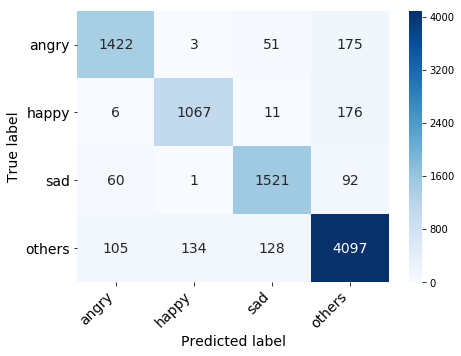

In [62]:
y_pred_val = get_predictions(model, x_val, y_val) # best.h5

True Positives per class :  [1474. 1155. 1497. 4239.]
False Positives per class :  [141. 107.  86. 350.]
False Negatives per class :  [177. 105. 177. 225.]

Class angry : Precision : 0.913, Recall : 0.893, F1 : 0.903
Class happy : Precision : 0.915, Recall : 0.917, F1 : 0.916
Class sad : Precision : 0.946, Recall : 0.894, F1 : 0.919

Ignoring the Others class, Macro Precision : 0.9245, Macro Recall : 0.9012, Macro F1 : 0.9127
Ignoring the Others class, Micro TP : 4126, FP : 334, FN : 459

Accuracy : 0.9244, Micro Precision : 0.9251, Micro Recall : 0.8999, Micro F1 : 0.9123


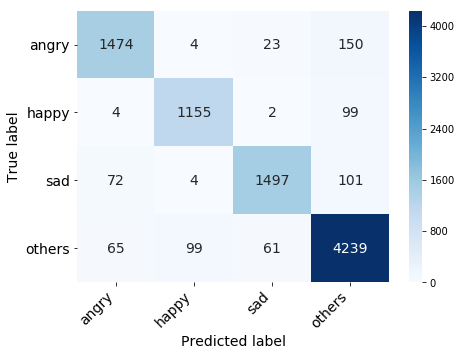

In [57]:
y_pred_val = get_predictions(last_best, x_val, y_val) # Last Best

#### Test set

True Positives per class :  [ 125.  105.  101. 2133.]
False Positives per class :  [85. 62. 69. 75.]
False Negatives per class :  [ 25.  37.  24. 205.]

Class angry : Precision : 0.595, Recall : 0.833, F1 : 0.694
Class happy : Precision : 0.629, Recall : 0.739, F1 : 0.680
Class sad : Precision : 0.594, Recall : 0.808, F1 : 0.685

Ignoring the Others class, Macro Precision : 0.6060, Macro Recall : 0.7936, Macro F1 : 0.6872
Ignoring the Others class, Micro TP : 331, FP : 216, FN : 86

Accuracy : 0.8944, Micro Precision : 0.6051, Micro Recall : 0.7938, Micro F1 : 0.6867


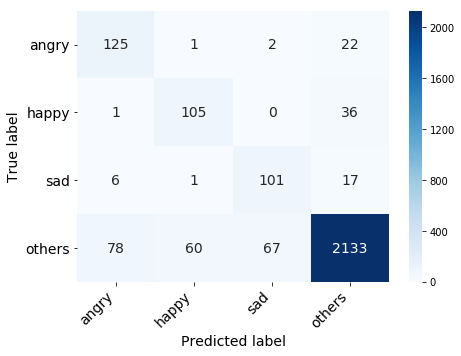

In [63]:
y_pred_test = get_predictions(model, X_test, y_test) # best.h5

True Positives per class :  [ 127.  109.   97. 2141.]
False Positives per class :  [92. 76. 41. 72.]
False Negatives per class :  [ 23.  33.  28. 197.]

Class angry : Precision : 0.580, Recall : 0.847, F1 : 0.688
Class happy : Precision : 0.589, Recall : 0.768, F1 : 0.667
Class sad : Precision : 0.703, Recall : 0.776, F1 : 0.738

Ignoring the Others class, Macro Precision : 0.6240, Macro Recall : 0.7968, Macro F1 : 0.6999
Ignoring the Others class, Micro TP : 333, FP : 209, FN : 84

Accuracy : 0.8980, Micro Precision : 0.6144, Micro Recall : 0.7986, Micro F1 : 0.6945


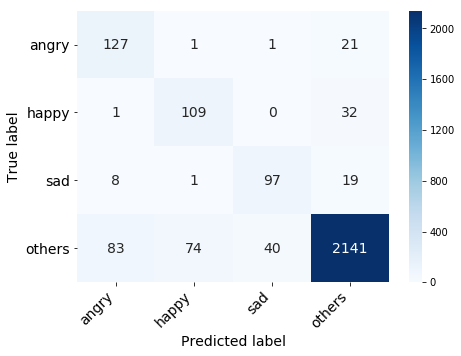

In [58]:
y_pred_test = get_predictions(last_best, X_test, y_test) # Last Best

In [32]:
model.save('pickles/models/val_acc_?-tst_f1_?-res_f1_?.h5')

### Generating a submission file

In [64]:
y_pred_sub = generate_predictions(model, 'data/test.txt', word_index=word_index)

Loading dataset...
Reading twitter - 1grams ...
Reading twitter - 2grams ...


Preprocessing...:   0%|          | 0/2755 [00:00<?, ?it/s]

Reading twitter - 1grams ...


Preprocessing...: 100%|██████████| 2755/2755 [00:00<00:00, 2928.88it/s]


Generating Predictions...
Done. Wrote submission.txt file at project's root


In [81]:
from src.dataset import load_submission_dataset
from src.evaluate import label2emotion


_, df_sub = load_submission_dataset('data/test.txt')

df_sub['label'] = np.vectorize(lambda x: label2emotion[x])(lreg_pred_sub.argmax(axis=1))

with open('submission.txt', 'w') as file:
    df_sub.to_csv(path_or_buf=file, sep='\t', index=False)

Reading twitter - 1grams ...
Reading twitter - 2grams ...


Preprocessing...:   0%|          | 0/2755 [00:00<?, ?it/s]

Reading twitter - 1grams ...


Preprocessing...: 100%|██████████| 2755/2755 [00:01<00:00, 2717.28it/s]
